# ZeroShot Tutorial

This notebook demonstrates the use of the `FewShotX` package (version 0.1.2), available for download [here](https://github.com/RenatoVassallo/BSE-ForecastNLP/releases/download/0.1.2/fewshotx-0.1.2-py3-none-any.whl).

## Text Classification for Economic/Financial Headlines

In this tutorial, we will work with a synthetic text corpus from **Econland** consisting of 100 headlines labeled as financial or non-financial (`is_financial = 1 or 0`). 

In [1]:
import pandas as pd

url = "https://github.com/RenatoVassallo/FewShotX/raw/main/src/FewShotX/datasets/econland_corpus.csv"

# Read the CSV directly from the raw link
df_corpus = pd.read_csv(url).sample(100, random_state=42)
df_corpus = df_corpus[["headline", "is_financial"]].reset_index(drop=True)
df_corpus.head()

,headline,is_financial
0,The central bank signaled a pause in interest ...,1
1,Investors show growing confidence in emerging ...,1
2,City Council Debates Infrastructure Plan,0
3,Investment in Tech Sector Slows Amid Global Un...,1
4,New coach implements strict budgeting for play...,0


## 1. **Text Embedding:**  
   
- We embed the texts using the lightweight sentence transformer model `all-MiniLM-L6-v2`.

In [2]:
from FewShotX import Embeddings

embedder = Embeddings(model_name='all-MiniLM-L6-v2')
df_embed = embedder.embed_df(df_corpus, text_col='headline')
df_embed.head()

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

,headline,is_financial,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383,probably_truncated
0,The central bank signaled a pause in interest ...,1,-0.007948,-0.085992,-0.033172,0.031979,0.099065,-0.029061,-0.055636,0.041970,...,-0.083569,-0.067497,-0.005186,-0.088711,-0.029747,-0.056450,-0.078135,-0.037645,-0.034123,False
1,Investors show growing confidence in emerging ...,1,0.092125,-0.084598,0.053874,0.069822,0.055076,-0.026801,0.033874,0.016588,...,0.050521,-0.056351,0.000738,-0.061882,0.004574,-0.019279,-0.088336,-0.074426,0.063286,False
2,City Council Debates Infrastructure Plan,0,0.002158,0.032092,0.054396,-0.000520,0.021640,-0.063238,-0.024402,-0.017707,...,0.002707,-0.026037,-0.019030,-0.072301,0.044119,0.000802,0.052589,0.013683,0.038093,False
3,Investment in Tech Sector Slows Amid Global Un...,1,0.110281,-0.057388,0.028717,-0.001929,0.026695,-0.095883,-0.000819,-0.031363,...,-0.014941,0.027281,-0.041317,-0.099908,0.003284,-0.060359,-0.154623,0.022379,0.001173,False
4,New coach implements strict budgeting for play...,0,-0.008120,0.041354,-0.044605,-0.015570,-0.022977,0.054477,0.016323,0.029771,...,0.034670,-0.017184,-0.006992,-0.101925,-0.087460,-0.022215,-0.049012,-0.025572,0.000098,False


## 2. **Zero-Shot Classification:**  

- We use the `ZeroShot` class to compute similarity scores between the text embeddings and the embedded label(s).

In [3]:
from FewShotX import ZeroShotLearner

labels = ["This example is about economics or finance"]

zs1 = ZeroShotLearner(embedder.model, similarity='cosine')
scored_df1 = zs1.score_df(df=df_embed.copy(),
                          text_embedding_cols=[f"emb_{i}" for i in range(embedder.embedding_dim)],
                          labels=labels,
                          label_names=["is_financial_zs1"],)
scored_df1 = scored_df1[["headline", "is_financial", "is_financial_zs1"]]
scored_df1.head()

,headline,is_financial,is_financial_zs1
0,The central bank signaled a pause in interest ...,1,0.640908
1,Investors show growing confidence in emerging ...,1,0.621988
2,City Council Debates Infrastructure Plan,0,0.561130
3,Investment in Tech Sector Slows Amid Global Un...,1,0.653375
4,New coach implements strict budgeting for play...,0,0.643089


## 3. **Natural Language Inference (NLI):**  

- We apply a zero-shot NLI model to assess whether a given text (premise) entails or contradicts a hypothesis.

In [4]:
from FewShotX import ZeroShotNLI

zs2 = ZeroShotNLI(model_name='facebook/bart-large-mnli', hypothesis_template="This example is about {}.")
labels = ["economics or finance"]
scored_df2 = zs2.score_df(scored_df1, text_col="headline", labels=labels, label_names=["is_financial_zs2"])
scored_df2.head()

Scoring with ZeroShotNLI: 100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


,headline,is_financial,is_financial_zs1,is_financial_zs2
0,The central bank signaled a pause in interest ...,1,0.640908,0.299651
1,Investors show growing confidence in emerging ...,1,0.621988,0.175709
2,City Council Debates Infrastructure Plan,0,0.561130,0.018355
3,Investment in Tech Sector Slows Amid Global Un...,1,0.653375,0.005072
4,New coach implements strict budgeting for play...,0,0.643089,0.847157


## 4. **Performance Evaluation:**  
   
- We compare the performance of both classifiers using ROC-AUC and Precision-Recall curves.

In [5]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Extract relevant columns
y_true = scored_df2["is_financial"]
y_pred1 = scored_df2["is_financial_zs1"]
y_pred2 = scored_df2["is_financial_zs2"]

# Function to find the optimal threshold based on F1 Score
def optimal_threshold(y_true, y_pred):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

# Calculate optimal thresholds
threshold1 = optimal_threshold(y_true, y_pred1)
threshold2 = optimal_threshold(y_true, y_pred2)

print(f"Optimal Threshold for ZS1: {threshold1:.4f}")
print(f"Optimal Threshold for ZS2: {threshold2:.4f}")

# Generate predictions using optimal thresholds
scored_df2["pred_zs1"] = (y_pred1 >= threshold1).astype(int)
scored_df2["pred_zs2"] = (y_pred2 >= threshold2).astype(int)

# Save the scored DataFrame
scored_df2.head()

Optimal Threshold for ZS1: 0.5635
Optimal Threshold for ZS2: 0.0051


,headline,is_financial,is_financial_zs1,is_financial_zs2,pred_zs1,pred_zs2
0,The central bank signaled a pause in interest ...,1,0.640908,0.299651,1,1
1,Investors show growing confidence in emerging ...,1,0.621988,0.175709,1,1
2,City Council Debates Infrastructure Plan,0,0.561130,0.018355,0,1
3,Investment in Tech Sector Slows Amid Global Un...,1,0.653375,0.005072,1,1
4,New coach implements strict budgeting for play...,0,0.643089,0.847157,1,1


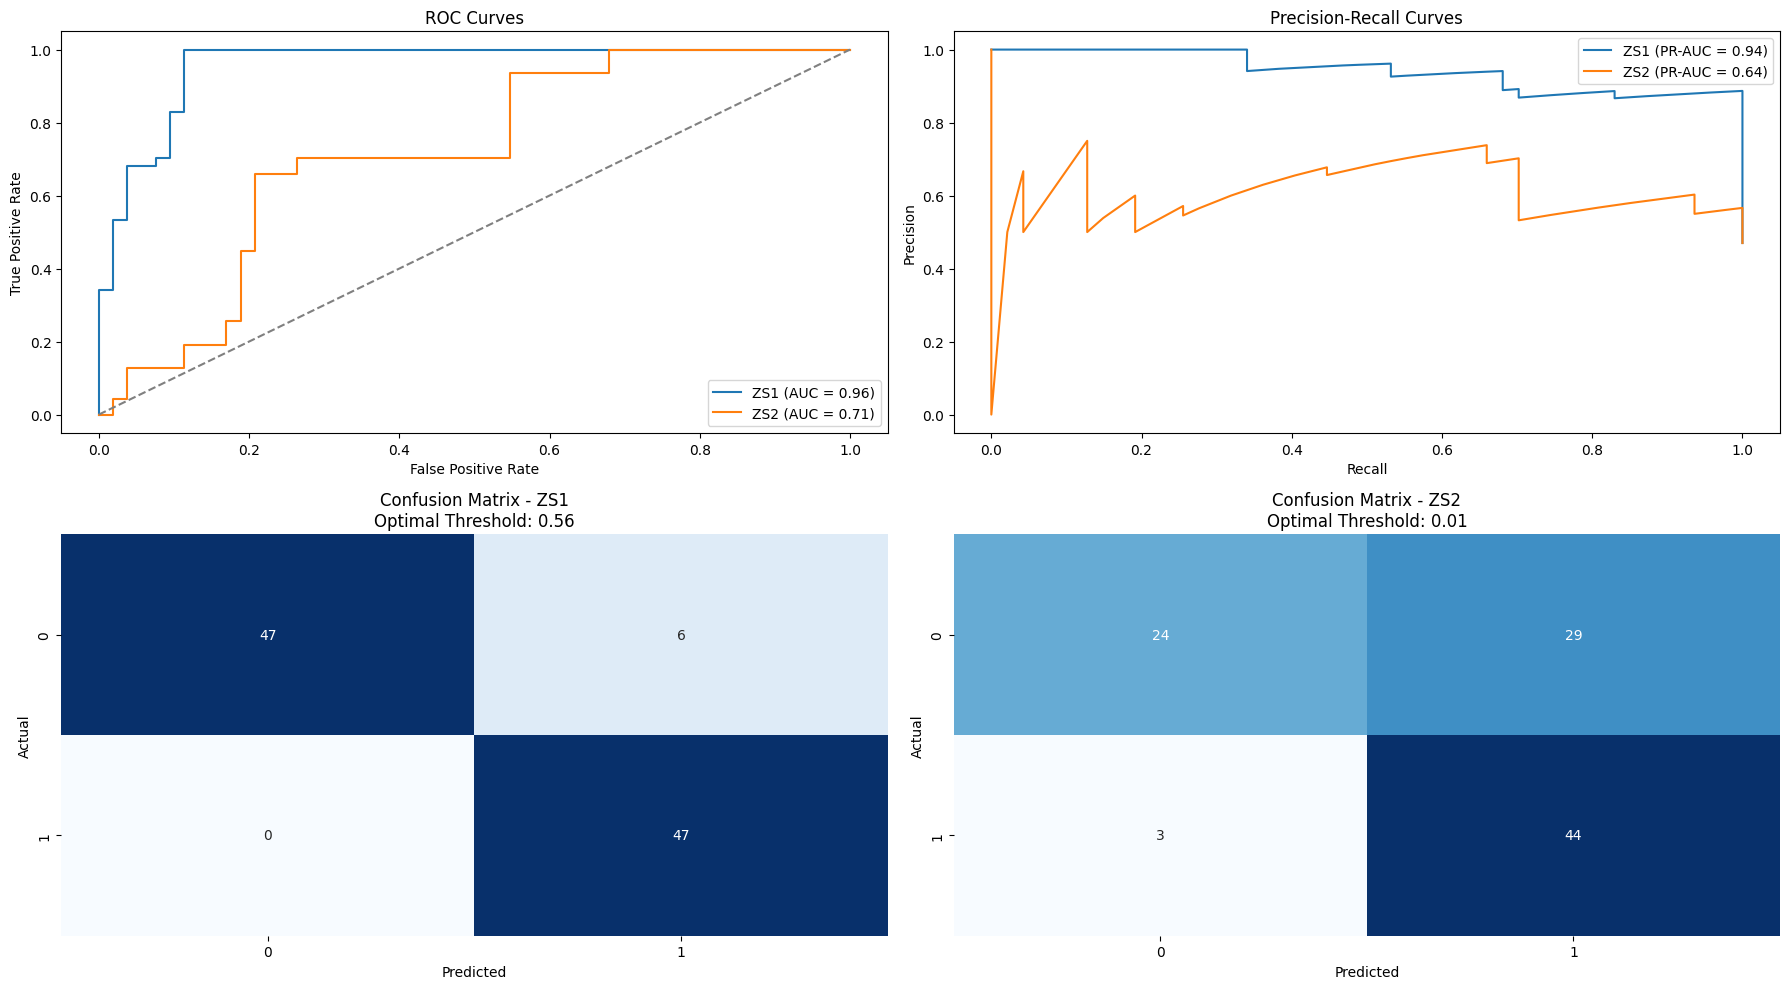

In [6]:
from FewShotX import evaluate_predictions

evaluate_predictions(
    y_true=scored_df2["is_financial"], 
    ZS1=scored_df2["is_financial_zs1"], 
    ZS2=scored_df2["is_financial_zs2"]
)